<a href="https://colab.research.google.com/github/lazarovps/Data-Science/blob/main/Previs%C3%A3o_Pesquisa_Mensal_do_Com%C3%A9rcio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prevendo o volume de vendas do setor de alimentação e bebidas

## Introdução

O planejamento produtivo é essencial para qualquer tipo de atividade, com ele, a empresa pode se preparar e realizar uma gestão de estoques eficiente, sem excessos e sem escassez. Para que esse planejamento seja completo, é necessário ter a capacidade de fazer previsões das vendas no curto e médio prazo, com vista nisso, pretende-se através de aplicação de algoritmos de Machine Learning, fazer a previsão do volume de vendas do setor de "Hipermercados, Supermercados, produtos alimentícios, bebidas e fumo", baseado nos resultados da Pesquisa Mensal do Comércio (PMC), para a previsão, além da própria variável, também foram pensadas como variáveis explicativas a Taxa SELIC e a taxa de desocupação.

A Pesquisa Mensal do Comércio (PMC) é uma pesquisa realizada desde 1995 com empresas grandes, médias e pequenas que capta a receita e o volume de vendas dessas empresas, tendo como objetivo acompanhar o desempenho do comércio no país. Inicialmente era realizada apenas no Rio de Janeiro, hoje fornece índices à nível nacional e até a nível estadual (para algumas Unidades Federativas). Além de um fornecer um caráter  mais geral do comércio no país, a pesquisa também fornece indicadores setoriais, sendo do setores:

♦ Comércio Varejista;

♦ Combustíveis e lubrificantes;

♦ Hipermercados, Supermercados, produtos alimentícios, bebidas e fumo;

♦ Hipermercados e Supermercados;

♦ Tecidos, vestuários e calçados;

♦ Móveis e eletrodomésticos;

♦ Móveis;

♦ Artigos farmacêuticos;

♦ Livros, jornais, revistas e papelaria;

♦ Equipamentos e materiais para escritório;

♦ Outros artigos de uso pessoal e doméstico;

## Variáveis


#### Índice do volume de vendas do setor de alimentação e bebidas (variável dependente)

A variável alvo será o índice do volume de vendas no comércio varejista das atividades de "Hipermercados, Supermercados, produtos alimentícios e fumo". O índice tem base fixa, sendo 2014 o número-índice(2014=100). Por simplicidade, quando nos referirmos à essa variável, chamaremos-a apenas de PMC.

#### Taxa SELIC (variável independente)

A Taxa SELIC é a taxa de juros básica da economia, sendo o principal instrumento monetário para combate do aumento do nível de preços, a inflação. A SELIC é tomada como base para várias operações e contratos financeiros. Empiricamente, espera-se que um aumento da SELIC faça com que o nível de atividade caia, a lógica para isso é que:
SELIC sobe;
Juros aumenta;
Financiamento e empréstimos mais caros / Desencoraja o consumo;
Nível de atividade diminui;

Relação esperada com a variável-alvo: Negativa

#### Taxa de desocupação (variável independente)

A taxa de desocupação mede a proporção de pessoas com mais de 14 anos que estão desocupadas em relação às pessoas que estão em idade ativa que estão na força de trabalho (trabalhando ou não). Essa é uma das principais taxas de uma economia, a relação dela com o volume de vendas é mais clara: Taxa de desocupação sobe; menos pessoas trabalhando; menor o nível de atividade econômica; Menor o volume de vendas.

Relação esperada com a variável-alvo: Negativa

## Dados

Os dados serão coletados de duas fontes: Banco Central do Brasil - Sistema Gerenciador de Séries Temporaris (BACEN-SGS) e Sistema IBGE de Recuperação Automática (SIDRA). Para tanto, necessitamos basicamente do código de cada variável, no próprio site do BACEN-SGS é possível pesquisar a série desejada e descobrir seu código (link: https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries). Feita as pesquisas, encontra-se que:

### Códigos  das séries utilizadas:
11 - Taxas de juros- Selic (BACEN)

3418 - Índices de volume de vendas no comércio varejista, por tipos de atividades (2014 = 100) - (SIDRA)

24369 - Taxa de desocupação - PNADC (BACEN)

## Importação das bibliotecas

In [1]:
import matplotlib.pyplot as plt #Plotar gráficos
import numpy as np #manipulações numéricas
import pandas as pd #manipulações de tabelas/Dataframes
import requests #Para requisição dos dados da API
import seaborn as sns #plotar gráficos
import sidrapy #Pegar dados diretamente do SIDRA-IBGE
import warnings #Para suprimir avisos
warnings.filterwarnings('ignore') #Suprimindo os avisos

from datetime import datetime as dt #Manipulação de datas
from pmdarima.arima import auto_arima #auto_arima
from scipy.stats import shapiro,zscore #teste Shapiro-Wilk para normalidade, Teste Z
from sklearn.linear_model import LinearRegression #regressão linear
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error #Métricas
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #Plots de autocorrelação e parcial autocorrelação 
from statsmodels.tsa.arima_model import ARIMA #ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição dos elementos de séries temporais
from statsmodels.tsa.statespace.sarimax import SARIMAX #SARIMAX
from statsmodels.tsa.stattools import adfuller #teste para estacionariedade

### Criando algumas funções

In [2]:
#Pegar dados da API do BACEN:
def consulta_bacen(codigo_serie, data_inicial, data_final, nome_col):
    codigo_serie = codigo_serie
    data_inicial = data_inicial
    data_final = data_final
    nome_col
    url = f'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_serie}/dados?formato=json&dataInicial={data_inicial}&dataFinal={data_final}'
    df = pd.read_json(url)
    df = pd.DataFrame(df)
    df.columns = ['data',nome_col]
    return df


#MAPE (Mean Absolute Percentage Error):
def mape(y_true,y_predict):
    y_true, y_predict = np.array(y_true), np.array(y_predict)
    mape = np.mean(np.abs((y_true - y_predict)/y_predict * 100))
    return round(mape,2)

## Importação e manipulação dos dados

In [3]:
#Importação da série histórica da Taxa SELIC, o período selecionado será de 2012 até os últimos dados.
tx_selic = consulta_bacen(1178,'01/01/2012','01/11/2021','selic')

In [4]:
#Visualizando as primeiras linhas
tx_selic.head()

,data,selic
0,30/12/2011,10.91
1,02/01/2012,10.90
2,03/01/2012,10.90
3,04/01/2012,10.90
4,05/01/2012,10.90


In [5]:
tx_selic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    2471 non-null   object 
 1   selic   2471 non-null   float64
dtypes: float64(1), object(1)
memory usage: 38.7+ KB


In [6]:
#Transformando o tipo da coluna 'data'(As datas não foram reconhecidas como datas e sim como strings)
tx_selic['data'] = pd.to_datetime(tx_selic['data'], format = '%d/%m/%Y')

In [7]:
#Extraindo ano, mês e dia de cada data para posterior manipulação
tx_selic['ano_s'] = pd.DatetimeIndex(tx_selic['data']).year
tx_selic['mes_s'] = pd.DatetimeIndex(tx_selic['data']).month
tx_selic['dia_s'] = pd.DatetimeIndex(tx_selic['data']).day

In [8]:
tx_selic.head()

,data,selic,ano_s,mes_s,dia_s
0,2011-12-30,10.91,2011,12,30
1,2012-01-02,10.90,2012,1,2
2,2012-01-03,10.90,2012,1,3
3,2012-01-04,10.90,2012,1,4
4,2012-01-05,10.90,2012,1,5


In [9]:
tx_selic.tail()

,data,selic,ano_s,mes_s,dia_s
2466,2021-10-26,6.15,2021,10,26
2467,2021-10-27,6.15,2021,10,27
2468,2021-10-28,7.65,2021,10,28
2469,2021-10-29,7.65,2021,10,29
2470,2021-11-01,7.65,2021,11,1


O ideal para dados mensais é trabalhar sempre com o dia 01, vemos que esses dados não estão dentro desse padrão, já que não temos informação do dia 01/01/2012 (só há os valores para os dias úteis) então, temos que fazer uma rápida manipulação nesses dados.

In [10]:
#Criando um objeto com todos os dias do período 01/01/2012 até 01/01/2022
datas = pd.date_range(start = '1/1/2012', end = '1/1/2022', freq = 'D')

In [11]:
#Transformando-o em Dataframe e escolhendo a data com index
datas = pd.DataFrame(datas, columns =['data'])
datas.set_index('data', inplace = True)
tx_selic.set_index('data', inplace = True)

In [12]:
#Criando uma coluna para conseguir juntar com outro DataFrame
datas['coluna'] = np.arange(1,len(datas)+1)

In [13]:
datas.head()

,coluna
data,
2012-01-01,1
2012-01-02,2
2012-01-03,3
2012-01-04,4
2012-01-05,5


In [14]:
#Finalmente juntando os DataFrames
tx_selic_fin = tx_selic.merge(datas, how = 'right', left_index = True, right_index = True)

In [15]:
#Agora temos um DataFrame com todos os dias do período e alguns desses valores estão com NaN (Not a Number),
#iremos substituir esses valores pelos valores imediatamente posteriores, nesse caso, se o dia 01/01/2012 está ausente, iremos preenche-lo com os dados do dia 02/01/2012.
tx_selic_fin.head()

,selic,ano_s,mes_s,dia_s,coluna
data,,,,,
2012-01-01,NaN,NaN,NaN,NaN,1
2012-01-02,10.9,2012.0,1.0,2.0,2
2012-01-03,10.9,2012.0,1.0,3.0,3
2012-01-04,10.9,2012.0,1.0,4.0,4
2012-01-05,10.9,2012.0,1.0,5.0,5


In [16]:
tx_selic_fin.tail()

,selic,ano_s,mes_s,dia_s,coluna
data,,,,,
2021-12-28,NaN,NaN,NaN,NaN,3650
2021-12-29,NaN,NaN,NaN,NaN,3651
2021-12-30,NaN,NaN,NaN,NaN,3652
2021-12-31,NaN,NaN,NaN,NaN,3653
2022-01-01,NaN,NaN,NaN,NaN,3654


Agora temos um DataFrame com todos os dias do período e alguns desses valores estão com NaN (Not a Number),iremos substituir esses valores pelos valores imediatamente posteriores, nesse caso, se o dia 01/01/2012 está ausente, iremos preenche-lo com os dados do dia 02/01/2012.

In [17]:
#Preenchendo os valores vazios com valor posterior
tx_selic_fin = tx_selic_fin.fillna(method = 'backfill')

In [18]:
tx_selic_fin.head()

,selic,ano_s,mes_s,dia_s,coluna
data,,,,,
2012-01-01,10.9,2012.0,1.0,2.0,1
2012-01-02,10.9,2012.0,1.0,2.0,2
2012-01-03,10.9,2012.0,1.0,3.0,3
2012-01-04,10.9,2012.0,1.0,4.0,4
2012-01-05,10.9,2012.0,1.0,5.0,5


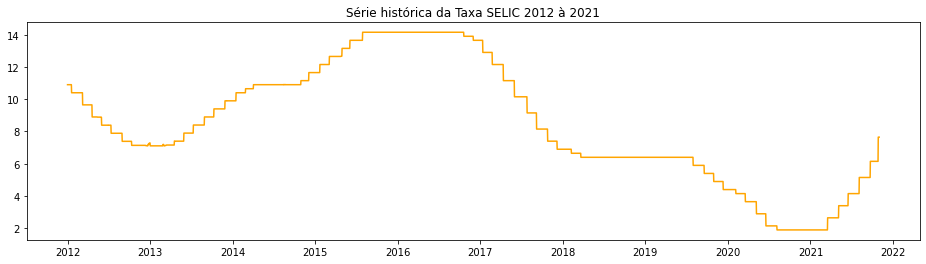

In [19]:
#Fazendo uma rápida visualização dos dados
plt.figure(figsize = (16,4))
plt.plot(tx_selic_fin['selic'], c = 'orange')
plt.title("Série histórica da Taxa SELIC 2012 à 2021")
plt.show()

In [20]:
#Importando a série histórica da taxa de desocupação
desocupacao = consulta_bacen(24369, '01/01/2012','01/11/2021','tx_desocup')

In [21]:
desocupacao.head()

,data,tx_desocup
0,01/03/2012,7.9
1,01/04/2012,7.7
2,01/05/2012,7.6
3,01/06/2012,7.5
4,01/07/2012,7.4


In [22]:
desocupacao.tail()

,data,tx_desocup
109,01/04/2021,14.7
110,01/05/2021,14.6
111,01/06/2021,14.1
112,01/07/2021,13.7
113,01/08/2021,13.2


Percebe-se que o último dado desse DataFrame é de agosto/2021, isso é esperado, já que há uma relativa defasagem na divulgação de dados à nível nacional.

In [23]:
desocupacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   data        114 non-null    object 
 1   tx_desocup  114 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


In [24]:
#Novamente, criando uma coluna 'data' já no formato desejado
desocupacao['data'] = pd.to_datetime(desocupacao['data'], format = '%d/%m/%Y')

In [25]:
desocupacao.head()

,data,tx_desocup
0,2012-03-01,7.9
1,2012-04-01,7.7
2,2012-05-01,7.6
3,2012-06-01,7.5
4,2012-07-01,7.4


Para a importação da PMC e de outras séries próprias do IBGE, podemos utilizar a API do IBGE (link: https://servicodados.ibge.gov.br/api/docs). Ao escolher a série, filtros e parâmetros do nosso interesse teremos uma URL. Essa URL que será utilizada na função que criamos inicialmente para fazer a captura desses dados

In [26]:
url_pmc_alim = 'https://servicodados.ibge.gov.br/api/v3/agregados/3418/periodos/200001|200002|200003|200004|200005|200006|200007|200008|200009|200010|200011|200012|200101|200102|200103|200104|200105|200106|200107|200108|200109|200110|200111|200112|200201|200202|200203|200204|200205|200206|200207|200208|200209|200210|200211|200212|200301|200302|200303|200304|200305|200306|200307|200308|200309|200310|200311|200312|200401|200402|200403|200404|200405|200406|200407|200408|200409|200410|200411|200412|200501|200502|200503|200504|200505|200506|200507|200508|200509|200510|200511|200512|200601|200602|200603|200604|200605|200606|200607|200608|200609|200610|200611|200612|200701|200702|200703|200704|200705|200706|200707|200708|200709|200710|200711|200712|200801|200802|200803|200804|200805|200806|200807|200808|200809|200810|200811|200812|200901|200902|200903|200904|200905|200906|200907|200908|200909|200910|200911|200912|201001|201002|201003|201004|201005|201006|201007|201008|201009|201010|201011|201012|201101|201102|201103|201104|201105|201106|201107|201108|201109|201110|201111|201112|201201|201202|201203|201204|201205|201206|201207|201208|201209|201210|201211|201212|201301|201302|201303|201304|201305|201306|201307|201308|201309|201310|201311|201312|201401|201402|201403|201404|201405|201406|201407|201408|201409|201410|201411|201412|201501|201502|201503|201504|201505|201506|201507|201508|201509|201510|201511|201512|201601|201602|201603|201604|201605|201606|201607|201608|201609|201610|201611|201612|201701|201702|201703|201704|201705|201706|201707|201708|201709|201710|201711|201712|201801|201802|201803|201804|201805|201806|201807|201808|201809|201810|201811|201812|201901|201902|201903|201904|201905|201906|201907|201908|201909|201910|201911|201912|202001|202002|202003|202004|202005|202006|202007|202008|202009|202010|202011|202012|202101|202102|202103|202104|202105|202106|202107|202108/variaveis/564?localidades=N1&classificacao=11046[40311]|85[90672]'

In [27]:
#Lendo a URL em JSON
pmc_alim = requests.get(url_pmc_alim).json()

In [28]:
#Visualizando o objeto criado
pmc_alim

[{'id': '564',
  'resultados': [{'classificacoes': [{'categoria': {'40311': 'Índice base fixa (2014=100)'},
      'id': '11046',
      'nome': 'Tipos de índice'},
     {'categoria': {'90672': 'Hipermercados, supermercados, produtos alimentícios, bebidas e fumo'},
      'id': '85',
      'nome': 'Atividades'}],
    'series': [{'localidade': {'id': '1',
       'nivel': {'id': 'N1', 'nome': 'Brasil'},
       'nome': 'Brasil'},
      'serie': {'200001': '54.3',
       '200002': '53.9',
       '200003': '57.2',
       '200004': '58.3',
       '200005': '55.8',
       '200006': '55.8',
       '200007': '57.9',
       '200008': '57.1',
       '200009': '57.4',
       '200010': '56.8',
       '200011': '57.1',
       '200012': '75.6',
       '200101': '56.1',
       '200102': '54.3',
       '200103': '60.0',
       '200104': '58.7',
       '200105': '56.0',
       '200106': '56.1',
       '200107': '56.1',
       '200108': '57.1',
       '200109': '57.1',
       '200110': '57.9',
       '20011

In [29]:
#Acessando os valores da série e salvando-os em um objeto
data_list = list(pmc_alim[0]['resultados'][0]['series'][0]['serie'].items())

In [30]:
#Transformando o objeto em um DataFrame
base = pd.DataFrame(data_list)

In [31]:
#Verificando se saiu conforme o imaginado
base.head()

,0,1
0,200001,54.3
1,200002,53.9
2,200003,57.2
3,200004,58.3
4,200005,55.8


In [32]:
#Renomeando as colunas
base.columns = ['codigo_mes','pmc_alimentacao']

In [33]:
#Criando uma coluna para data, ano e mes
base['data'] = pd.to_datetime(base['codigo_mes'], format ='%Y%m')
base['ano'] = pd.DatetimeIndex(base['data']).year
base['mes'] = pd.DatetimeIndex(base['data']).month

In [34]:
#mesclando com o DataFrame "desocupacao"
base = base.merge(desocupacao, on = 'data')

In [35]:
#mesclando com o DataFrame "tx_selic_fin"
base = base.merge(tx_selic_fin, on = 'data')

In [36]:
#Selecionando a data como index
base.set_index('data', inplace = True)

In [37]:
#Por fim temos a base de dados final
base.head()

,codigo_mes,pmc_alimentacao,ano,mes,tx_desocup,selic,ano_s,mes_s,dia_s,coluna
data,,,,,,,,,,
2012-03-01,201203,98.8,2012,3,7.9,10.40,2012.0,3.0,1.0,61
2012-04-01,201204,94.6,2012,4,7.7,9.65,2012.0,4.0,2.0,92
2012-05-01,201205,92.6,2012,5,7.6,8.90,2012.0,5.0,2.0,122
2012-06-01,201206,93.3,2012,6,7.5,8.39,2012.0,6.0,1.0,153
2012-07-01,201207,94.0,2012,7,7.4,8.39,2012.0,7.0,2.0,183


In [38]:
base.tail()

,codigo_mes,pmc_alimentacao,ano,mes,tx_desocup,selic,ano_s,mes_s,dia_s,coluna
data,,,,,,,,,,
2021-04-01,202104,99.1,2021,4,14.7,2.65,2021.0,4.0,1.0,3379
2021-05-01,202105,101.0,2021,5,14.6,2.65,2021.0,5.0,3.0,3409
2021-06-01,202106,97.4,2021,6,14.1,3.40,2021.0,6.0,1.0,3440
2021-07-01,202107,103.8,2021,7,13.7,4.15,2021.0,7.0,1.0,3470
2021-08-01,202108,100.6,2021,8,13.2,4.15,2021.0,8.0,2.0,3501


In [39]:
base.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2012-03-01 to 2021-08-01
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   codigo_mes       114 non-null    object 
 1   pmc_alimentacao  114 non-null    object 
 2   ano              114 non-null    int64  
 3   mes              114 non-null    int64  
 4   tx_desocup       114 non-null    float64
 5   selic            114 non-null    float64
 6   ano_s            114 non-null    float64
 7   mes_s            114 non-null    float64
 8   dia_s            114 non-null    float64
 9   coluna           114 non-null    int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 9.8+ KB


In [40]:
#Transformando o tipo da coluna 'pmc_alimentacao' (os valores estão sendo lidos como strings)
base['pmc_alimentacao'] = base['pmc_alimentacao'].astype('float64')

In [41]:
#Dropando algumas colunas que não são mais necessárias
base.drop(['codigo_mes','ano_s','mes_s','dia_s','coluna'], axis = 1, inplace = True)

In [42]:
#Dividindo os dados entre treino e teste. os últimos 12 meses serão os dados de teste.
treino = base.iloc[:-12]
teste = base.iloc[-12:]

In [43]:
treino.shape, teste.shape

((102, 5), (12, 5))

In [44]:
treino.tail()

,pmc_alimentacao,ano,mes,tx_desocup,selic
data,,,,,
2020-04-01,100.9,2020,4,12.6,3.65
2020-05-01,105.5,2020,5,12.9,3.65
2020-06-01,100.5,2020,6,13.3,2.90
2020-07-01,105.6,2020,7,13.8,2.15
2020-08-01,105.5,2020,8,14.5,2.15


In [45]:
teste.head()

,pmc_alimentacao,ano,mes,tx_desocup,selic
data,,,,,
2020-09-01,100.5,2020,9,14.6,1.9
2020-10-01,108.5,2020,10,14.3,1.9
2020-11-01,103.2,2020,11,14.1,1.9
2020-12-01,123.1,2020,12,13.9,1.9
2021-01-01,98.1,2021,1,14.2,1.9


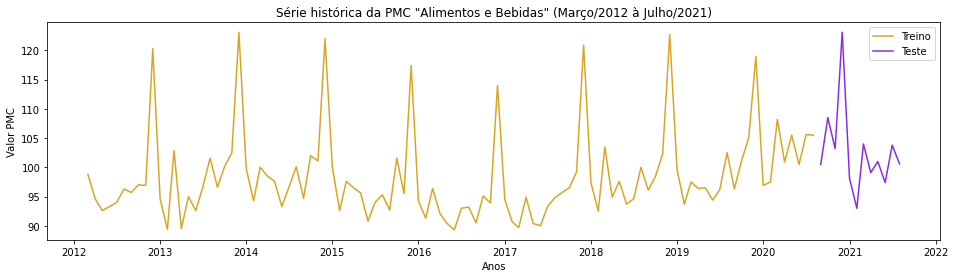

In [46]:
#Plotando a série histórica já dividida em treino e teste
plt.figure(figsize = (16,4))
plt.plot(treino['pmc_alimentacao'], label = 'Treino', c = 'goldenrod')
plt.plot(teste['pmc_alimentacao'], label = 'Teste', c = 'blueviolet')
plt.title('Série histórica da PMC "Alimentos e Bebidas" (Março/2012 à Julho/2021)')
plt.legend(loc = 'best')
plt.xlabel('Anos')
plt.ylabel('Valor PMC')
plt.show()

## Análise Exploratória de Dados

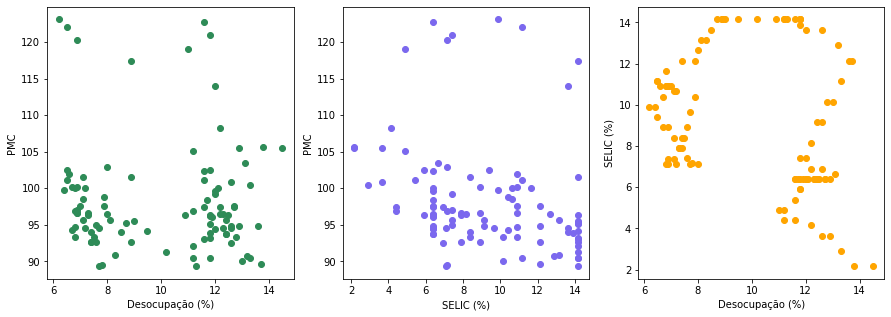

In [47]:
#Verificando a relação entre as variáveis
fig, axes = plt.subplots(1,3, figsize = (15,5))
axes[0].scatter(treino['tx_desocup'],treino['pmc_alimentacao'], c = 'seagreen')
axes[0].set_xlabel('Desocupação (%)')
axes[0].set_ylabel('PMC')

axes[1].scatter(treino['selic'],treino['pmc_alimentacao'], c = 'mediumslateblue')
axes[1].set_xlabel('SELIC (%)')
axes[1].set_ylabel('PMC')

axes[2].scatter(treino['tx_desocup'],treino['selic'], c = 'orange')
axes[2].set_xlabel('Desocupação (%)')
axes[2].set_ylabel('SELIC (%)')

plt.show()

In [48]:
base.corr()

,pmc_alimentacao,ano,mes,tx_desocup,selic
pmc_alimentacao,1.000000,0.150447,0.509798,0.024913,-0.308958
ano,0.150447,1.000000,-0.110171,0.901707,-0.591518
mes,0.509798,-0.110171,1.000000,-0.085246,0.004091
tx_desocup,0.024913,0.901707,-0.085246,1.000000,-0.466514
selic,-0.308958,-0.591518,0.004091,-0.466514,1.000000


Quando olhamos para as correlações, vemos que a taxa de desocupação tem uma correlação muito fraca mas positiva com a PMC, indo contra a nossa intuição inicial. Já a relação entre a taxa SELIC e a PMC foi, mesmo fraca, negativa, corroborando nosso raciocínio. Além disso, também observamos a relação entre a taxa de desocupação e a SELIC,que aparenta ser uma função de máximo, onde para níveis iniciais ambas estão positivamente correlacionadas e após certo ponto passa a ter um comportamento indefinido/negativo.

Em economia, algumas relações não são instantâneas, por isso, é necessário visualizar se há alguma correlação das variáveis com defasagem de tempo, ou seja, se uma variável x no períodoo t-1,t-2 ou t-3 possui relação com uma variável y no período t. Primeiro visualizemos essa relação entre a PMC e a taxa de desocupação.

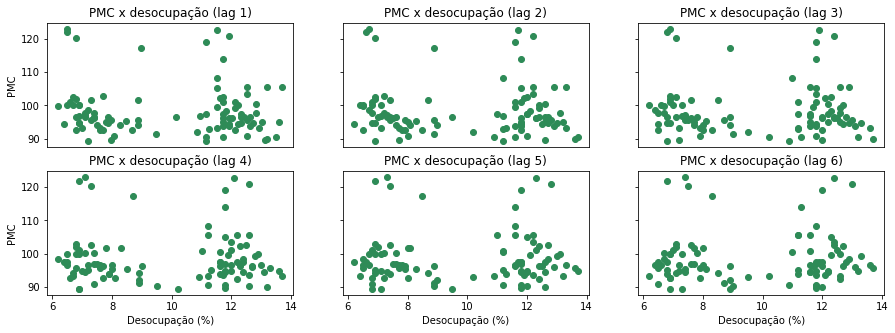

In [49]:
#Verificando a relação a PMC e a taxa de desocupação (com lags)
fig, axes = plt.subplots(2,3, figsize = (15,5), sharey = True)
axes[0,0].scatter(treino['tx_desocup'].shift(1),treino['pmc_alimentacao'], c = 'seagreen')
axes[0,0].set_ylabel('PMC')
axes[0,0].set_xticks([])
axes[0,0].set_title('PMC x desocupação (lag 1)')

axes[0,1].scatter(treino['tx_desocup'].shift(2),treino['pmc_alimentacao'], c = 'seagreen')
axes[0,1].set_xticks([])
axes[0,1].set_title('PMC x desocupação (lag 2)')

axes[0,2].scatter(treino['tx_desocup'].shift(3),treino['pmc_alimentacao'], c = 'seagreen')
axes[0,2].set_xticks([])
axes[0,2].set_title('PMC x desocupação (lag 3)')

axes[1,0].scatter(treino['tx_desocup'].shift(4),treino['pmc_alimentacao'], c = 'seagreen')
axes[1,0].set_xlabel('Desocupação (%)')
axes[1,0].set_ylabel('PMC')
axes[1,0].set_title('PMC x desocupação (lag 4)')

axes[1,1].scatter(treino['tx_desocup'].shift(5),treino['pmc_alimentacao'], c = 'seagreen')
axes[1,1].set_xlabel('Desocupação (%)')
axes[1,1].set_title('PMC x desocupação (lag 5)')


axes[1,2].scatter(treino['tx_desocup'].shift(6),treino['pmc_alimentacao'], c = 'seagreen')
axes[1,2].set_xlabel('Desocupação (%)')
axes[1,2].set_title('PMC x desocupação (lag 6)')

plt.show()

O que pode-se perceber com os plots anteriores é que há naturalmente a criação de clusters, um mais à esquerda, com Desocupação <10 e outro mais à direita.

Realizando a mesma análise com a PMC e a SELIC temos:

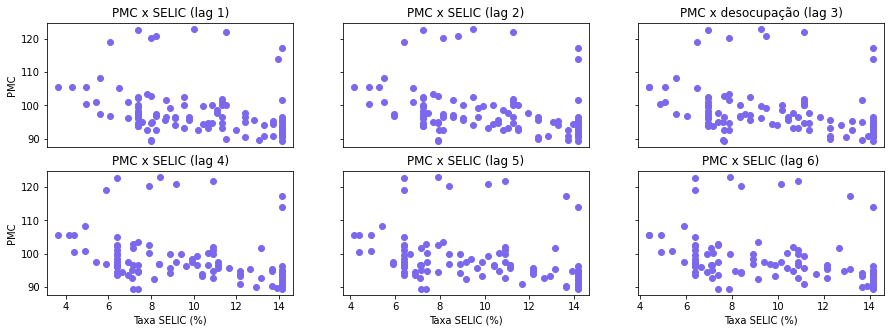

In [50]:
#Verificando a relação a PMC e a Taxa SELIC (com lags)
fig, axes = plt.subplots(2,3, figsize = (15,5), sharey = True)
axes[0,0].scatter(treino['selic'].shift(1),treino['pmc_alimentacao'], c = 'mediumslateblue')
axes[0,0].set_ylabel('PMC')
axes[0,0].set_xticks([])
axes[0,0].set_title('PMC x SELIC (lag 1)')

axes[0,1].scatter(treino['selic'].shift(2),treino['pmc_alimentacao'], c = 'mediumslateblue')
axes[0,1].set_xticks([])
axes[0,1].set_title('PMC x SELIC (lag 2)')

axes[0,2].scatter(treino['selic'].shift(3),treino['pmc_alimentacao'], c = 'mediumslateblue')
axes[0,2].set_xticks([])
axes[0,2].set_title('PMC x desocupação (lag 3)')

axes[1,0].scatter(treino['selic'].shift(4),treino['pmc_alimentacao'], c = 'mediumslateblue')
axes[1,0].set_xlabel('Taxa SELIC (%)')
axes[1,0].set_ylabel('PMC')
axes[1,0].set_title('PMC x SELIC (lag 4)')

axes[1,1].scatter(treino['selic'].shift(5),treino['pmc_alimentacao'], c = 'mediumslateblue')
axes[1,1].set_xlabel('Taxa SELIC (%)')
axes[1,1].set_title('PMC x SELIC (lag 5)')


axes[1,2].scatter(treino['selic'].shift(6),treino['pmc_alimentacao'], c = 'mediumslateblue')
axes[1,2].set_xlabel('Taxa SELIC (%)')
axes[1,2].set_title('PMC x SELIC (lag 6)')

plt.show()

O padrão não se altera muito, quando consideramos uma PMC< 110, percebe uma correlação negativa entre as variáveis, como era esperado.

Além disso, podemos fazer uma análise ano a ano da variável-alvo para ver se conseguimos encontrar algum padrão de repetição, o que poderia indicar sazonalidade.

In [51]:
#Criando uma lista com os anos presentes nos dados
years = treino.ano.unique()

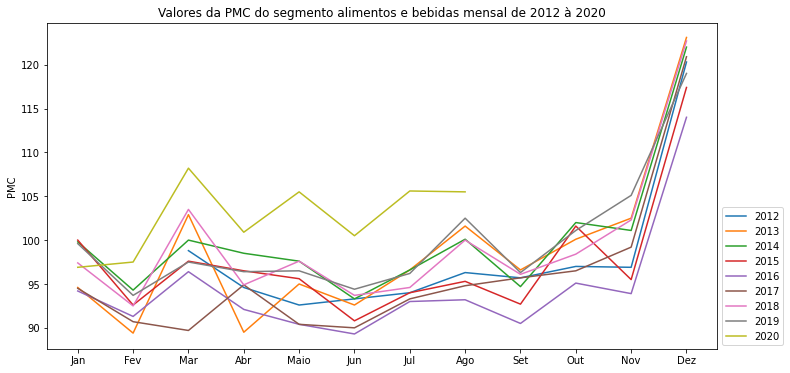

In [52]:
#Plotando os valores da PMC mês a mês por ano
pos_mes = np.arange(1,13)
meses = ['Jan','Fev','Mar','Abr','Maio','Jun','Jul','Ago','Set','Out','Nov','Dez']
plt.figure(figsize = (12,6))
for i in years:
    plt.plot('mes','pmc_alimentacao', data = treino[treino['ano'] == i], label = i)
plt.title('Valores da PMC do segmento alimentos e bebidas mensal de 2012 à 2020')
plt.legend(loc = 'best', bbox_to_anchor = (1,0.45))
plt.xticks(pos_mes,meses)
plt.ylabel('PMC')
plt.show()

Percebe-se que há padrão que se repete anualmente: O ano começa com a queda, em meados de março há um aumento, novamente seguid por queda, em agosto há uma nova ascensão, depois outra em outubro e como era de se esperar, dezembro o volume de vendas aumenta absurdamente.

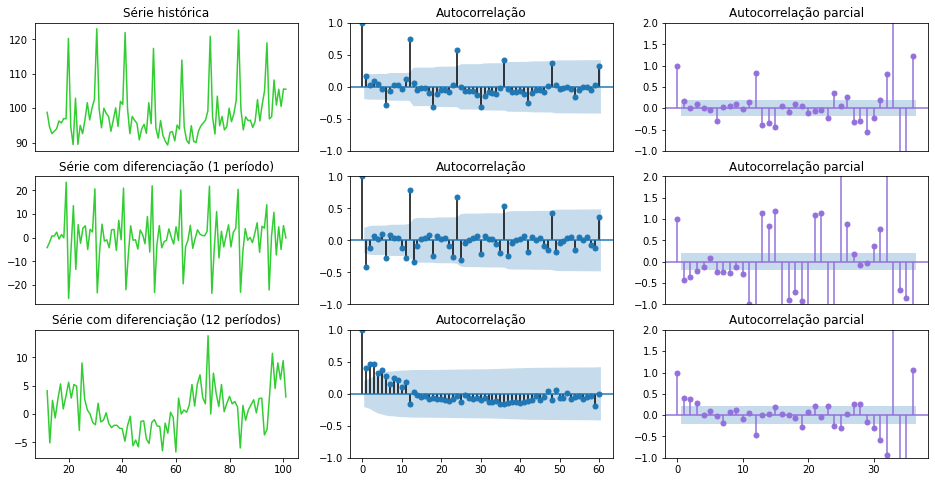

In [53]:
#Plotando a série histórica normal, com 1 lag e 12 lags, plots de autocorrelação e parcial autocorrelação
fig2, axes2 = plt.subplots(3,3, figsize = (16,8))
axes2[0,0].plot(treino['pmc_alimentacao'].reset_index(drop = True), c = 'limegreen'); axes2[0,0].set_title('Série histórica')
axes2[1,0].plot(treino['pmc_alimentacao'].reset_index(drop = True).diff(1), c = 'limegreen'); axes2[1,0].set_title('Série com diferenciação (1 período)')
axes2[2,0].plot(treino['pmc_alimentacao'].reset_index(drop = True).diff(12), c = 'limegreen'); axes2[2,0].set_title('Série com diferenciação (12 períodos)')
plot_acf(treino['pmc_alimentacao'], ax = axes2[0,1], lags = 60, title = 'Autocorrelação')
plot_acf(treino['pmc_alimentacao'].diff(1).dropna(), ax = axes2[1,1], lags = 60,title = 'Autocorrelação')
plot_acf(treino['pmc_alimentacao'].diff(12).dropna(), ax = axes2[2,1], lags = 60, title = 'Autocorrelação')
plot_pacf(treino['pmc_alimentacao'], ax = axes2[0,2], lags = 36, title = 'Autocorrelação parcial', c = 'mediumpurple', vlines_kwargs={'colors': 'mediumpurple'})
plot_pacf(treino['pmc_alimentacao'].diff(1).dropna(), ax = axes2[1,2], lags = 36, title = 'Autocorrelação parcial', c = 'mediumpurple', vlines_kwargs={'colors': 'mediumpurple'})
plot_pacf(treino['pmc_alimentacao'].diff(12).dropna(), ax = axes2[2,2], lags = 36, title = 'Autocorrelação parcial', c = 'mediumpurple', vlines_kwargs={'colors': 'mediumpurple'})
axes2[0,0].set_xticks([]); axes2[1,0].set_xticks([])
axes2[0,1].set_xticks([]); axes2[1,1].set_xticks([])
axes2[0,2].set_xticks([]); axes2[1,2].set_xticks([])
axes2[0,2].set(ylim=(-1,2));axes2[1,2].set(ylim=(-1,2));axes2[2,2].set(ylim=(-1,2))
plt.show()

Nos plots acima, percebe-se que a série quase não muda após uma diferença, mas quando fazemos a diferença considerando a sazonalidade anual, os padrões da série tornam mais claro, então é a partir disso que iremos basear nossa análise.

In [54]:
#Teste para verificar estacionariedade (série histórica)
adfuller(treino['pmc_alimentacao'])

(-0.6301640267237689,
 0.8640195006967502,
 13,
 88,
 {'1%': -3.506944401824286,
  '10%': -2.584614550619835,
  '5%': -2.894989819214876},
 476.80240854155034)

In [55]:
#Teste para verificar estacionariedade (12 períodos de lag)
adfuller(treino['pmc_alimentacao'].diff(12).dropna())

(-2.7102646497172547,
 0.07227881699412195,
 11,
 78,
 {'1%': -3.517113604831504,
  '10%': -2.5869547797501644,
  '5%': -2.8993754262546574},
 396.4801039429889)

In [56]:
#PROCURANDO OS PARÂMETROS ÓTIMOS 
sarima = auto_arima(treino['pmc_alimentacao'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=515.942, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=462.968, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=482.457, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=462.474, Time=0.25 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.25 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=493.752, Time=0.20 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=445.301, Time=0.37 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=447.137, Time=0.14 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.10 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=446.510, Time=0.39 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=446.321, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  102
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -217.650
Date:                            Mon, 22 Nov 2021   AIC                            445.301
Time:                                    11:47:47   BIC                            457.744
Sample:                                         0   HQIC                           450.316
                                            - 102                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8089      0.108     -7.524      0.000      -1.020      -0.598
ar.L2         -0.4470      0.106     -4.232      0.000      -0.654      -0.240
ar.S.L12      -0.6970      0.142     -4.911      0.000      -0.975      -0.419
ar.S.L24      -0.2402      0.161     -1.488      0.137      -0.557       0.076
sigma2         7.2193      1.328      5.438      0.000       4.617       9.821
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 2.23
Prob(Q):                              0.74   Prob(JB):                         0.33
Heteroskedasticity (H):               1.69   Skew:                             0.33
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

O algoritmo encontrou uma combinação que minimiza o AIC (Akaike Information Criterion - Mensura a qualidade e simplicidade de um algoritmo, quanto menor, melhor é o modelo), esses parâmetros foram:
p = 2 
d = 1 
q = 0 
P = 2
D = 1
Q = 0

In [57]:
model01 = SARIMAX(treino['pmc_alimentacao'], order =(2,1,0), seasonal_order = (2,1,0,12), freq = 'MS').fit()
model02 = SARIMAX(treino['pmc_alimentacao'], exog = treino['tx_desocup'], order =(2,1,0), seasonal_order = (2,1,0,12), freq = 'MS').fit()
model03 = SARIMAX(treino['pmc_alimentacao'], exog = treino['selic'], order =(2,1,0), seasonal_order = (2,1,0,12), freq = 'MS').fit()
model04 = SARIMAX(treino['pmc_alimentacao'], exog = treino[['tx_desocup','selic']], order =(2,1,0), seasonal_order = (2,1,0,12), freq = 'MS').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [58]:
residuos01 = model01.resid
residuos02 = model02.resid
residuos03 = model03.resid
residuos04 = model04.resid

In [59]:
#Teste para verificar a normalidade dos resíduos
print(f'P-valor para a normalidade dos resíduos:\nModelo 01: {shapiro(residuos01)[1]}')
print(f'Modelo 02: {shapiro(residuos02)[1]}')
print(f'Modelo 03: {shapiro(residuos03)[1]}')
print(f'Modelo 04: {shapiro(residuos04)[1]}')

P-valor para a normalidade dos resíduos:
Modelo 01: 1.0967233088152962e-18
Modelo 02: 7.952688634001327e-19
Modelo 03: 7.624576070298746e-19
Modelo 04: 5.853319748978228e-19


Todos os modelos possuem fortes indícios de possuem os erros das previsões normalmente distribuídos, então, temos embasamento para acreditar que o modelo foi bem especificado.

In [60]:
#Fazendo a previsão de cada modelo e comparando os com os dados de teste
y_predictlast = teste['pmc_alimentacao'].shift(-1) #Modelo baseline - último valor
y_predict01 = model01.forecast(12)
y_predict02 = model02.forecast(12, exog = teste['tx_desocup'])
y_predict03 = model03.forecast(12, exog = teste['selic'])
y_predict04 = model04.forecast(12, exog = teste[['tx_desocup','selic']])

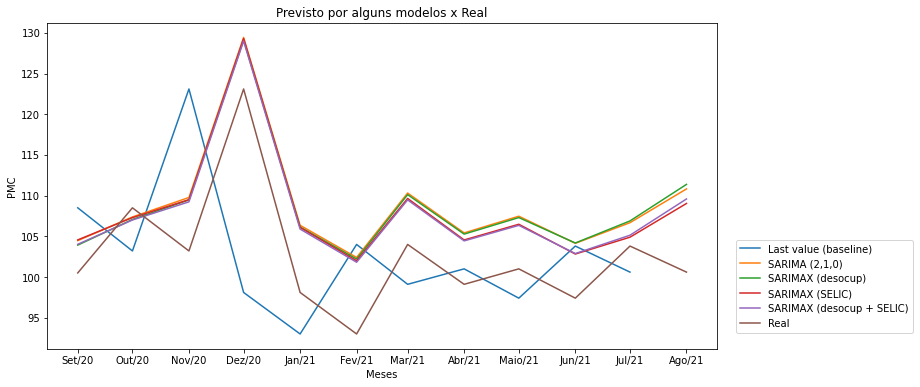

In [61]:
pos_mes = pd.date_range(start = teste.index[0],end = teste.index[-1], freq = 'MS')
meses = ['Set/20','Out/20','Nov/20','Dez/20','Jan/21','Fev/21','Mar/21','Abr/21','Maio/21','Jun/21','Jul/21','Ago/21']
plt.figure( figsize = (12,6))
plt.plot(y_predictlast, label = 'Last value (baseline)')
plt.plot(y_predict01, label = 'SARIMA (2,1,0)')
plt.plot(y_predict02, label = 'SARIMAX (desocup)')
plt.plot(y_predict03, label = 'SARIMAX (SELIC)')
plt.plot(y_predict04, label = 'SARIMAX (desocup + SELIC)')
plt.plot(teste['pmc_alimentacao'], label = 'Real')
plt.legend(loc = 'best', bbox_to_anchor = (1.30,0.35))
plt.title('Previsto por alguns modelos x Real')
plt.xlabel('Meses')
plt.ylabel('PMC')
plt.xticks(pos_mes,meses)
plt.show()

In [62]:
mape01 = mape(teste['pmc_alimentacao'],y_predict01)
mape02 = mape(teste['pmc_alimentacao'],y_predict02)
mape03 = mape(teste['pmc_alimentacao'],y_predict03)
mape04 = mape(teste['pmc_alimentacao'],y_predict04)
mapelast = mape(teste['pmc_alimentacao'].iloc[:-1], y_predictlast.iloc[:-1])

In [63]:
print(f'MAPE SARIMA (2,1,0): {mape01}%\nMAPE SARIMAX (desocup): {mape02}%\nMAPE SARIMAX (SELIC): {mape03}%\nMAPE SARIMAX (desocup + SELIC): {mape04}%\nMAPE Last value: {mapelast}%')

MAPE SARIMA (2,1,0): 5.73%
MAPE SARIMAX (desocup): 5.66%
MAPE SARIMAX (SELIC): 5.12%
MAPE SARIMAX (desocup + SELIC): 5.07%
MAPE Last value: 8.19%


O modelo que apresentou o melhor resultado (menor MAPE) foi o que leva em conta a SELIC, mas, para fins de previsão, iremos levar em conta apenas o modelo autoregressivo com sazonalidade (SARIMA).

### Modelo final

In [64]:
modelfinal = SARIMAX(base['pmc_alimentacao'], order =(2,1,0), seasonal_order = (2,1,0,12), freq = 'MS').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [65]:
predict_final = modelfinal.forecast(6)

In [66]:
modelfinal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    pmc_alimentacao   No. Observations:                  114
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -249.000
Date:                            Mon, 22 Nov 2021   AIC                            508.000
Time:                                    11:47:51   BIC                            521.076
Sample:                                03-01-2012   HQIC                           513.294
                                     - 08-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7952      0.100     -7.983      0.000      -0.990      -0.600
ar.L2         -0.4293      0.097     -4.433      0.000      -0.619      -0.239
ar.S.L12      -0.5765      0.124     -4.649      0.000      -0.820      -0.333
ar.S.L24      -0.1724      0.155     -1.115      0.265      -0.475       0.131
sigma2         7.7297      1.375      5.623      0.000       5.036      10.424
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.94   Prob(JB):                         0.43
Heteroskedasticity (H):               1.58   Skew:                             0.27
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

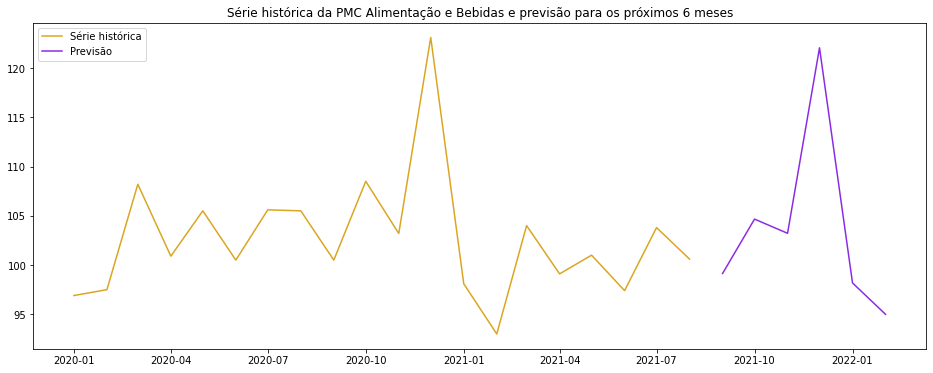

In [67]:
plt.figure(figsize= (16,6))
plt.plot(base[base['ano']>=2020]['pmc_alimentacao'], label = 'Série histórica', c = 'goldenrod')
plt.plot(predict_final, label = 'Previsão', c = 'blueviolet')
plt.title('Série histórica da PMC Alimentação e Bebidas e previsão para os próximos 6 meses')
plt.legend()
plt.show()

In [68]:
pred_2021 = predict_final.reset_index(drop = True)

In [69]:
#Salvando o index
index = predict_final.index.month

In [70]:
obs_2020 = teste['pmc_alimentacao'].head(6).reset_index(drop=True)

In [71]:
#Calculando a variação percentual em relação ao ano anterior
var_per = np.round(((pred_2021 - obs_2020)/obs_2020)*100,4)

In [72]:
var_per

0   -1.3540
1   -3.5372
2    0.0197
3   -0.8530
4    0.0803
5    2.1448
dtype: float64

In [73]:
for i in np.arange(0,6):
    print(f'A variação prevista do mês {index[i]} em relação ao ano anterior é de {var_per[i]}%')

A variação prevista do mês 9 em relação ao ano anterior é de -1.354%
A variação prevista do mês 10 em relação ao ano anterior é de -3.5372%
A variação prevista do mês 11 em relação ao ano anterior é de 0.0197%
A variação prevista do mês 12 em relação ao ano anterior é de -0.853%
A variação prevista do mês 1 em relação ao ano anterior é de 0.0803%
A variação prevista do mês 2 em relação ao ano anterior é de 2.1448%


Percebe-se então, que não há um padrão claro dos valores previsto em relação aos últimos valores. Lembrando que essa previsão é um valor médio, havendo margem para mais ou para menos.

### Conclusão

Tendo uma noção do volume de vendas previsto para cada mês, pode-se planejar com um maior embasamento o estoque, a fim de otimizá-lo. Sugere-se para análises semelhantes, levar em conta a PMC de outros setores como variáveis exógenas para a previsão da PMC desse setor, já que muitas cadeias produtivas são interligadas entre si.